In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("data/clean/fg_all_seasons_clean.csv", parse_dates=["game_date"])

# Chron sort is critical for career stats
df.sort_values(['game_date', 'game_seconds_remaining'], ascending=[True, False], inplace=True)

# Target variable
df["made"] = df["field_goal_result"].map({"made": 1, "missed": 0}).fillna(0).astype(int)

# features
df["distance"] = pd.to_numeric(df["kick_distance"], errors="coerce")
df["distance_sq"] = df["distance"] ** 2

# Game state features
df["mins_remaining"] = df["game_seconds_remaining"] / 60.0
df["abs_score_diff"] = df["score_differential"].abs()
df["is_home"] = (df["posteam"] == df["home_team"]).astype(int)
if 'surface' in df.columns:
    df['is_turf'] = df['surface'].str.contains('turf', case=False, na=False).astype(int)
else:
    print("Warning: 'surface' column not found. Defaulting 'is_turf' to 0.")
    df['is_turf'] = 0

# Season type (playoffs)
if 'season_type' in df.columns:
    df['is_playoff_game'] = (df['season_type'] == 'POST').astype(int)
else:
    print("Warning: 'season_type' column not found. Defaulting 'is_playoff_game' to 0.")
    df['is_playoff_game'] = 0

# Roof / outdoors
if 'roof' in df.columns:
    df['is_outdoors'] = df['roof'].str.contains('outdoors|open', case=False, na=False).astype(int)
else:
    print("Warning: 'roof' column not found. Defaulting 'is_outdoors' to 1.")
    df['is_outdoors'] = 1

# Advanced stats & weather
df["wp_pre"] = pd.to_numeric(df.get("wp"), errors="coerce")
df["ep_pre"] = pd.to_numeric(df.get("ep"), errors="coerce")
df["temp"] = pd.to_numeric(df.get("temp"), errors="coerce")
df["wind"] = pd.to_numeric(df.get("wind"), errors="coerce")

df['time_pressure'] = 1 / (1 + df['mins_remaining'])
df['score_pressure'] = 1 / (1 + df['abs_score_diff'])
df['clutch_wp'] = 1 - (np.abs(df['wp_pre'].fillna(0.5) - 0.5) * 2)


# Kicker form and career stats
df["kicker_recent_made"] = (df.groupby("kicker_player_name")["made"]
                              .transform(lambda s: s.shift().rolling(5, min_periods=1).mean())
                              .fillna(0.5))
df['kicker_career_attempts'] = df.groupby('kicker_player_name').cumcount()
df['kicker_career_pct'] = df.groupby('kicker_player_name')['made'].transform(lambda s: s.shift().expanding().mean()).fillna(0.82) # Fill first attempt with league avg

# CLUTCH INDEX
clutch_components = [
    'time_pressure',
    'score_pressure',
    'clutch_wp',
    'is_outdoors' 
]

# temp df with these components
clutch_df = df[clutch_components].copy()

# Scale the components so they are all on a level playing field
scaler = StandardScaler()
clutch_scaled = scaler.fit_transform(clutch_df)

# Create the index by simply adding the scaled components together
# A higher score will mean more pressure/difficulty
df['clutch_index'] = clutch_scaled.sum(axis=1)


# prep final model using the RFE-selected features
final_features = ['distance', 'distance_sq', 'temp', 'wind', 'kicker_career_attempts', 'kicker_career_pct']
df_model = df[final_features + ['made']].copy()

# Only impute columns if they exist in our final feature set
if 'temp' in df_model.columns:
    temp_median = df_model['temp'].median()
    df_model['temp'] = df_model['temp'].fillna(temp_median if pd.notna(temp_median) else 68)

if 'wind' in df_model.columns:
    df_model['wind'] = df_model['wind'].fillna(0)

if 'wp_pre' in df_model.columns:
    df_model['wp_pre'] = df_model['wp_pre'].fillna(0.5)

#FINAL training
X_final = df_model[final_features]
y_final = df_model['made']

final_scaler = StandardScaler()
X_final_scaled = final_scaler.fit_transform(X_final)

# USING the best 'C' value found by GridSearchCV  
# BALANCED CLASS WEIGHT FOR MOST OPITIMAL JOB AT IDENTIFYING MISSES (RARE CLASS)(PERCESION/RECALL TRADEOFF)
final_model = LogisticRegression(solver='liblinear', C=1, random_state=42, class_weight='balanced')
final_model.fit(X_final_scaled, y_final)


/var/folders/2y/wgyhdx8x1fl5mbj6cf3zh2lh0000gn/T/ipykernel_80492/599846496.py:8: DtypeWarning: Columns (49,215,216,217,222,224,226,227,228,229,230,231,232,240,241,242,250,251,252,256,258,259,260,262,263,277,302,303) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/clean/fg_all_seasons_clean.csv", parse_dates=["game_date"])


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


# Analysis: The Evolution of the NFL Field Goal Kicker

**Prepared by: Nisola Adebanjo**
**Date: August 17, 2025**

### Executive Summary
This analysis was prompted by the increasing frequency of long-range field goals and Cam Little's 70 yard FG make in preseason. I ask the question: are kickers becoming so powerful they could fundamentally change offensive strategy? 

The key finding is that while kickers are demonstrating a clear and significant improvement in **deep accuracy (50+ yards)**, the data does not suggest an imminent threat of 65+ yard field goals becoming routine. A predictive logistic regression model with **77% ROC AUC** accuracy reveals that the most significant factors determining success remain the fundamental physics of the kick—**distance and weather**—and the **kicker's career skill**, not what we commonly believe in, the situational pressure.

## Finding 1: The Anatomy of a Field Goal & What Drives Success?

To understand what truly drives the success of a field goal, I built a logistic regression model trained on over 25,000 field goal kicks since 2000. After optimizing and selecting the most impactful variables with GridSearchCV and RFE, the model's coefficients reveal a clear hierarchy of importance.

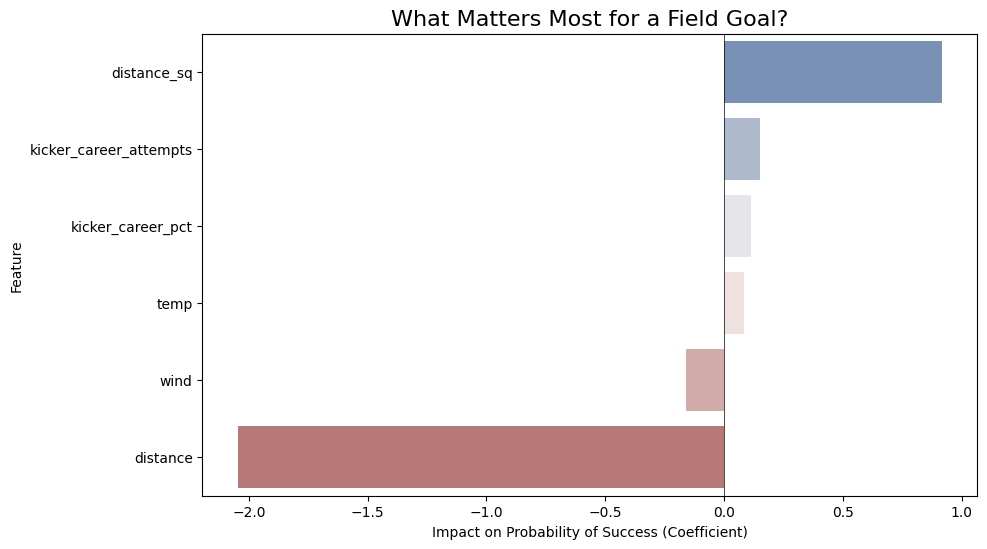

In [ ]:
coeffs = pd.DataFrame({
    'feature': X_final.columns,
    'coefficient': final_model.coef_[0]
}).sort_values('coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='coefficient', y='feature', data=coeffs,hue='feature', dodge=False, palette='vlag', legend=False)
plt.title("What Matters Most for a Field Goal?", size=16)
plt.xlabel("Impact on Probability of Success (Coefficient)")
plt.ylabel("Feature")
plt.axvline(0, color='k', linewidth=0.5)
plt.show()

### The Insight: Physics and Skill Reign Supreme.

The model confirms that **distance** is the single most dominant factor; every additional yard significantly decreases the probability of success. The next most important factors are the kicker's own demonstrated skill (**career accuracy and experience**) and environmental conditions like **wind**. These fundamental, physical factors were found to be far more predictive than any measure of situational pressure, which we care so much about today as fans.

## Finding 2: The Powerful Kicker is Already Here

While the *average* kick distance has remained flat for 20 years, this statistic is rather misleading. The true evolution of the position is happening at the elite and long-range level. When we isolate kicks of 55+ yards, a new story emerges and we see dramatically different results.

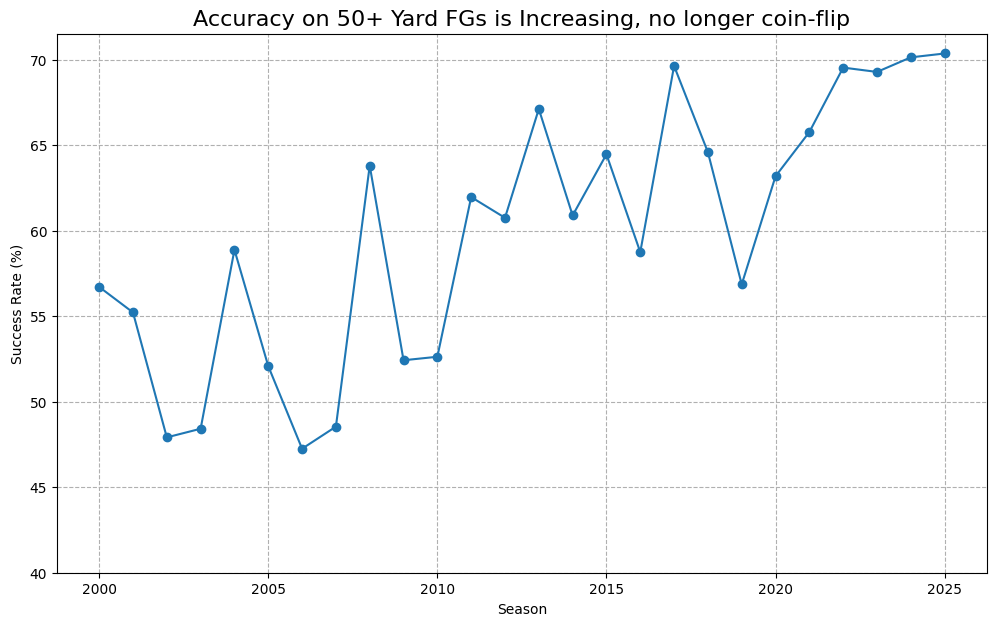

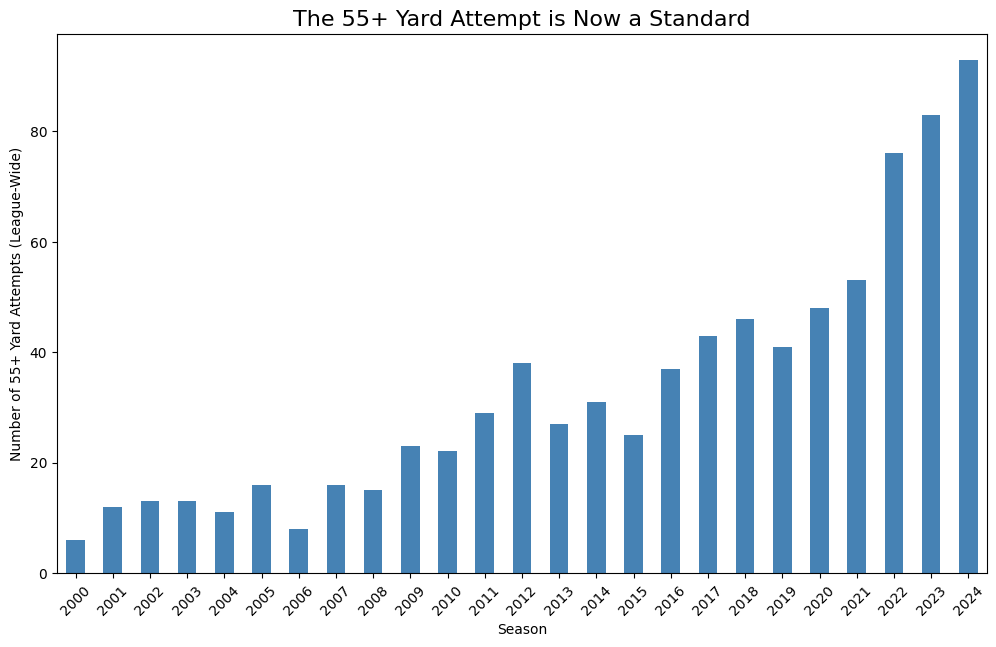

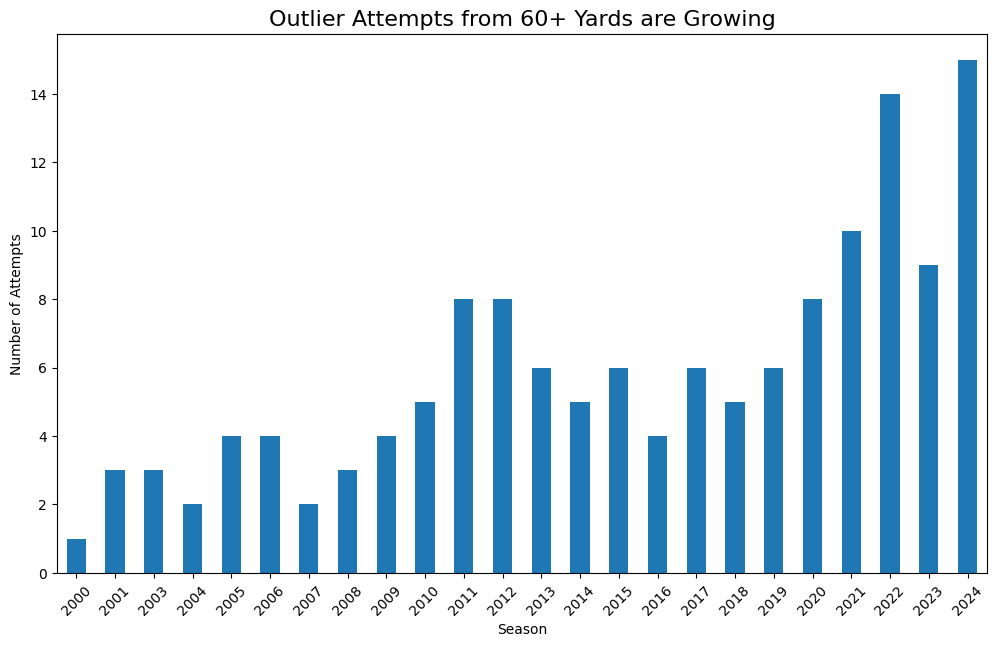

In [ ]:
# TIME-SERIES ANALYSIS
df['season'] = df['game_date'].dt.year
# Plot 1: Deep Accuracy (50+ yards)
plt.figure(figsize=(12, 7))
deep_kicks_df = df[df['distance'] >= 50]
deep_accuracy_per_season = deep_kicks_df.groupby('season')['made'].mean() * 100
deep_accuracy_per_season.plot(kind='line', marker='o')
plt.title("Accuracy on 50+ Yard FGs is Increasing, no longer coin-flip", size=16)
plt.ylabel("Success Rate (%)")
plt.xlabel("Season")
plt.grid(True, which='both', linestyle='--')
plt.ylim(bottom=40)
plt.show()
#plot
long_kicks_df = df[df['distance'] >= 55].copy()
long_attempts_per_season = long_kicks_df.groupby('season').size().drop(2025, errors='ignore')
plt.figure(figsize=(12, 7))
long_attempts_per_season.plot(kind='bar', color='steelblue')
plt.title("The 55+ Yard Attempt is Now a Standard", size=16)
plt.ylabel("# of 55+ Yard Attempts (League-Wide)")
plt.xlabel("Season")
plt.xticks(rotation=45)
plt.show()
# Outlier Attempts (60+ yards)
plt.figure(figsize=(12, 7))
outlier_kicks_per_season = df[df['distance'] >= 60].groupby('season').size()
outlier_kicks_per_season.plot(kind='bar')
plt.title("Outlier Attempts from 60+ Yards are Growing", size=16)
plt.ylabel("# of Attempts")
plt.xlabel("Season")
plt.xticks(rotation=45)
plt.show()

## Analysis: A Look at the Kicker Revolution

The data reveals a clear, statistically significant evolution of the avg kicker, moving the position from a specialty role to a strategic weapon. The narrative that kickers are becoming more powerful is not just anecdotal; it's a measurable trend with tangible, game-planning implications.

### Finding 1: The 50-Yard Kick is Now a High-Percentage Play.
The baseline for an elite kicker has fundamentally shifted. League-wide accuracy from 50+ yards has climbed from a ~55% success rate in the early 2000s to nearly **70%** in recent seasons. This **15-point increase** in efficiency has transformed what was once a low-probability attempt into a standard part of the offensive arsenal.

### Finding 2: The 55-Yard Attempt Has Gone Mainstream.
The most dramatic shift is in coaching confidence, which is evident in play-calling. Attempts from 55+ yards have increased by over **500%** since the early 2000s. The league now sees over **75 attempts per year** from this range, compared to just a handful historically. This isn't a gradual shift and shows us the fundamental change in fourth-down and end-of-half strategy.

### Projection: The 60+ Yard Threat is the Next Frontier.
While still rare, attempts from 60+ yards have doubled in the last decade alone. If this trend of adoption holds, the league is on pace to see over **50 attempts per season from 60+ yards by the 2030s**. What is now an outlier event is trending towards becoming a regular, game-planning consideration, confirming that the powerful kicker is actively reshaping the geometry of the field.

## Kicker Power Score

To capture both the increase in long-range attempts and makes, I created a **"Kicker Power Score"**—the sum of the distance of all made field goals from 55+ yards each season. This metric measures the total "long-range value" kickers are adding each year.

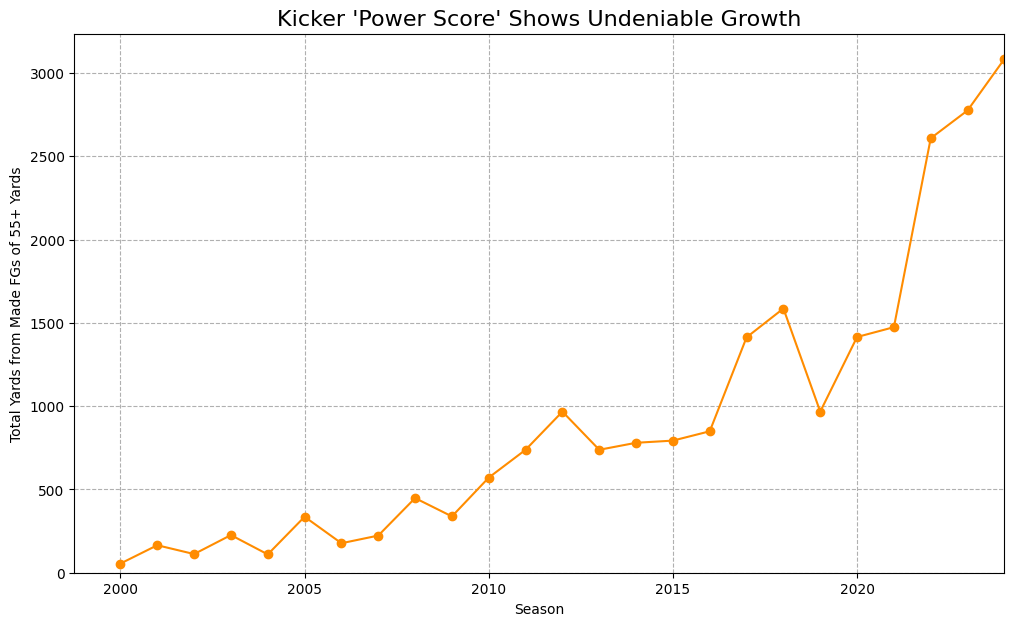

In [57]:
long_makes_df = long_kicks_df[long_kicks_df['made'] == 1].copy()
power_score_per_season = long_makes_df.groupby('season')['distance'].sum()

plt.figure(figsize=(12, 7))
power_score_per_season.plot(kind='line', marker='o', linestyle='-', color='darkorange')
plt.title("Kicker 'Power Score' Shows Undeniable Growth", size=16)
plt.ylabel("Total Yards from Made FGs of 55+ Yards")
plt.xlabel("Season")
plt.grid(True, which='both', linestyle='--')
plt.ylim(bottom=0)
plt.xlim(right=2024)
plt.show()

The data shows a **drastic 600 explosion** in the "Kicker Power Score" since 2000, driven by the weaponization and normalcy of the 55+ yard field goal. This exponential growth in long-range value creation confirms a fundamental shift in kicking capabilities, directly impacting fourth-down strategy and modern player evaluation.

Given the strategic value this provides, if this rate of improvement continues, the 60+ yard field goal is on a clear trajectory to evolve from a rare outlier into a routine weapon, changing the game we know as a whole!